# **Implémentation DDPG à la main**


On commence par découvrir l'environment gymnasium et le pendulumv1

In [21]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from gymnasium import Env, spaces
import math
import copy
import matplotlib.pyplot as plt
from IPython.display import clear_output

### **L'environment avec gymnasium**

In [2]:
video_folder = "./videos_test"

# Créer l'environnement avec enregistrement vidéo
env = gym.make("Pendulum-v1", render_mode="rgb_array")  # mode RGB pour enregistrer

# Envelopper avec RecordVideo pour capturer une vidéo
env = gym.wrappers.RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=lambda episode_id: True,  # enregistre chaque épisode
    name_prefix="pendulum-test"
)

obs, info = env.reset(seed=42)
print(f"Observation initiale : {obs}")

# Action constante (ex: couple maximum vers la droite)
constant_action = np.array([1.5])  # action ∈ [-2, 2]

for t in range(200):
    obs, reward, terminated, truncated, info = env.step(constant_action)
    done = terminated or truncated

    print(f"Step {t}")
    print(f"Observation : {obs}")
    print(f"Reward : {reward}")
    print("-" * 30)

    if done:
        break

env.close()
print(f"Vidéo enregistrée dans : {video_folder}")


C:\Users\Rémi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Rémi\Desktop\Poly\INF8225 - IA - Techniques Probabilistes et d'apprentissage\Projet\videos_test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Observation initiale : [-0.14995256  0.9886932  -0.12224312]
Step 0
Observation : [-0.19154312  0.9814842   0.8442768 ]
Reward : -2.9666752412400434
------------------------------
Step 1
Observation : [-0.27924106  0.96022105  1.8053899 ]
Reward : -3.183570002682552
------------------------------
Step 2
Observation : [-0.40824562  0.91287214  2.7505558 ]
Reward : -3.7647675473178843
------------------------------
Step 3
Observation : [-0.56756216  0.8233305   3.66021   ]
Reward : -4.724191830358519
------------------------------
Step 4
Observation : [-0.7370381  0.6758512  4.5027075]
Reward : -6.069710304937317
------------------------------
Step 5
Observation : [-0.88681513  0.46212438  5.2345963 ]
Reward : -7.787161277506971
------------------------------
Step 6
Observation : [-0.98198915  0.18893722  5.8061895 ]
Reward : -9.824353297598382
------------------------------
Step 7
Observation : [-0.9929794  -0.11828726  6.1728926 ]
Reward : -12.084861894304884
--------------------------

### **Architecture Actor / Critic**

In [49]:


torch.manual_seed(42)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(state_dim, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        x = torch.tanh(self.layer3(x))
        return self.max_action * x
    
    
    
# Exemple d'utilisation
state_dim = 3  # Par exemple, pour l'environnement Pendulum-v1
action_dim = 1  # Une seule action continue
max_action = 2.0  # La plage des actions est [-2, 2]

# Initialisation de l'acteur
actor = Actor(state_dim, action_dim, max_action)

# Exemple d'état
state = torch.tensor([[0.99998855, -0.00542783, -0.30779922]], dtype=torch.float32)

# Prédiction de l'action
action = actor(state)
print("Action prédite :", action)




class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.layer1 = nn.Linear(state_dim + action_dim, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 1)
        
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x
            
        
    
    # Exemple d'utilisation
state_dim = 3  # Par exemple, pour l'environnement Pendulum-v1
action_dim = 1  # Une seule action continue

# Initialisation du critique
critic = Critic(state_dim, action_dim)

# Exemple d'état et d'action
state = torch.tensor([[0.99998855, -0.00542783, -0.30779922]], dtype=torch.float32)
action = torch.tensor([[1.5]], dtype=torch.float32)

# Prédiction de la valeur Q
q_value = critic(state, action)
print("Valeur Q prédite :", q_value)


# On utilise Adam pour l'optimisation
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

Action prédite : tensor([[0.1786]], grad_fn=<MulBackward0>)
Valeur Q prédite : tensor([[-0.1693]], grad_fn=<AddmmBackward0>)


### **Replay Buffer pour garder accès aux expériences passées**

In [4]:
class ReplayBuffer:
    def __init__(self, size=100000):
        self.buffer = deque(maxlen=size) # Une file (deque) de taille maximale size pour stocker les transitions

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for transition in batch:
            state, action, reward, next_state, done = transition
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        
        return (
            torch.FloatTensor(states).view(batch_size, -1),
            torch.FloatTensor(actions).view(batch_size, -1),
            torch.FloatTensor(rewards).unsqueeze(1),
            torch.FloatTensor(next_states).view(batch_size, -1),
            torch.FloatTensor(dones).unsqueeze(1)
        )
    
    def __len__(self):
        return len(self.buffer)    


### **Génération de bruit pour l'exploration**

In [5]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(self, size: int, mu: float = 0.0, theta: float = 0.15, sigma: float = 0.2):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

### **Boucle Principale d'entrainement**

In [63]:
def train(mu , theta , sigma , initial_random_steps , num_episodes, batch_size, gamma, tau, duree_episode ):
    noise = OUNoise(size=action_dim, mu=mu , theta=theta, sigma=sigma)

    # Initialiser la figure pour le traçage des courbes
    plt.ion()  # Active le mode interactif
    fig, ax = plt.subplots(3, 1, figsize=(10, 15))
    # Initialiser les listes pour le traçage des courbes
    episode_rewards = []
    actor_losses = []
    critic_losses = []
    step = 0


    for episode in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        episode_reward = 0
        noise.reset() # Réinitialiser le bruit à chaque épisode

        for t in range(duree_episode):  # nombre d'etapes par episode
            step += 1
            # Sélectionner une action
            if step < initial_random_steps:
                action = env.action_space.sample()  # Action complètement aléatoire
            else:
                action = actor(state).detach().numpy().flatten()
            action += noise.sample()  #  bruit ajouté ici
            action = np.clip(action, -max_action, max_action)
                
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            reward = torch.tensor([reward], dtype=torch.float32)
            print(f"action", action, "state", state)
            reward_predicted = critic(state, torch.tensor(action, dtype=torch.float32).unsqueeze(0)).detach().numpy()
            print(f"State", state.numpy(), "Action", action, "Reward", reward.numpy(), "Récompense prédite", reward_predicted) 
            # Stocker l'expérience dans la mémoire de replay
            replay_buffer.add((state.numpy(), action, reward.numpy(), next_state.numpy(), done))

            # Mettre à jour l'état
            state = next_state
            #episode_reward += reward.item()
            # Ajouter les valeurs aux listes pour le traçage des courbes
            episode_rewards.append(reward)

            if done:
                break

            # Mettre à jour les réseaux si la mémoire de replay est suffisamment remplie
            if len(replay_buffer) > batch_size and step >= initial_random_steps:
                print("ok1")
                # Échantillonner un mini-batch
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                # Mettre à jour le critique
                target_q = rewards + gamma * target_critic(next_states, target_actor(next_states)) * (1 - dones)
                current_q = critic(states, actions)
                critic_loss = nn.MSELoss()(current_q, target_q.detach())

                critic_optimizer.zero_grad()
                critic_loss.backward()
                critic_optimizer.step()

                # Mettre à jour l'acteur
                actor_loss = -critic(states, actor(states)).mean()
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                # Mettre à jour les réseaux cibles
                for target_param, param in zip(target_critic.parameters(), critic.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
                for target_param, param in zip(target_actor.parameters(), actor.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        
        
        
                # Ajouter les pertes **seulement** si elles existent (après updates)
                if len(replay_buffer) > batch_size and step >= initial_random_steps:
                    print("ok2")
                    actor_losses.append(actor_loss.item())
                    critic_losses.append(critic_loss.item())
                else:
                    actor_losses.append(np.nan)
                    critic_losses.append(np.nan)

        if (episode + 1) % (1) == 0:   #200/duree_episode
            clear_output(True)
            plt.figure(figsize=(18, 5))

            # Reward
            plt.subplot(1, 3, 1)
            plt.title(f"Rewards frame {(episode+1)*duree_episode}")
            plt.plot(episode_rewards)
            plt.xlabel("Frame")
            plt.ylabel("Reward")

            # Actor Loss
            if actor_losses:  # si non vide
                plt.subplot(1, 3, 2)
                plt.title("Actor Loss")
                plt.plot(actor_losses)
                plt.xlabel("Updates")
                plt.ylabel("Loss")

            # Critic Loss
            if critic_losses:  # si non vide
                plt.subplot(1, 3, 3)
                plt.title("Critic Loss")
                plt.plot(critic_losses)
                plt.xlabel("Updates")
                plt.ylabel("Loss")

            plt.tight_layout()
            plt.show()
        
        
        print(f"Episode {episode + 1}, Reward moyen: {episode_reward}")

    env.close()

### **Nouvel environment d'entrainement très simplifié**

In [26]:
class SimpleEnv(Env):
    def __init__(self):
        super(SimpleEnv, self).__init__()
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        st = random.random()
        self.state = np.array([st], dtype=np.float32)
        
        
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        st = random.random()
        self.state = np.array([st], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        # Récompense maximale pour une action proche de 1, minimale pour une action proche de -1
        reward = math.sin(action[0] * np.pi)  #-action[0]
        st = random.random() 
        
        self.state = np.array([st], dtype=np.float32)  # L'état reste le même
        print(f"etat" , self.state)
        done = False
        truncated = False
        return self.state, reward, done, truncated, {}

### **Test sur l'environement personnalisé simple**

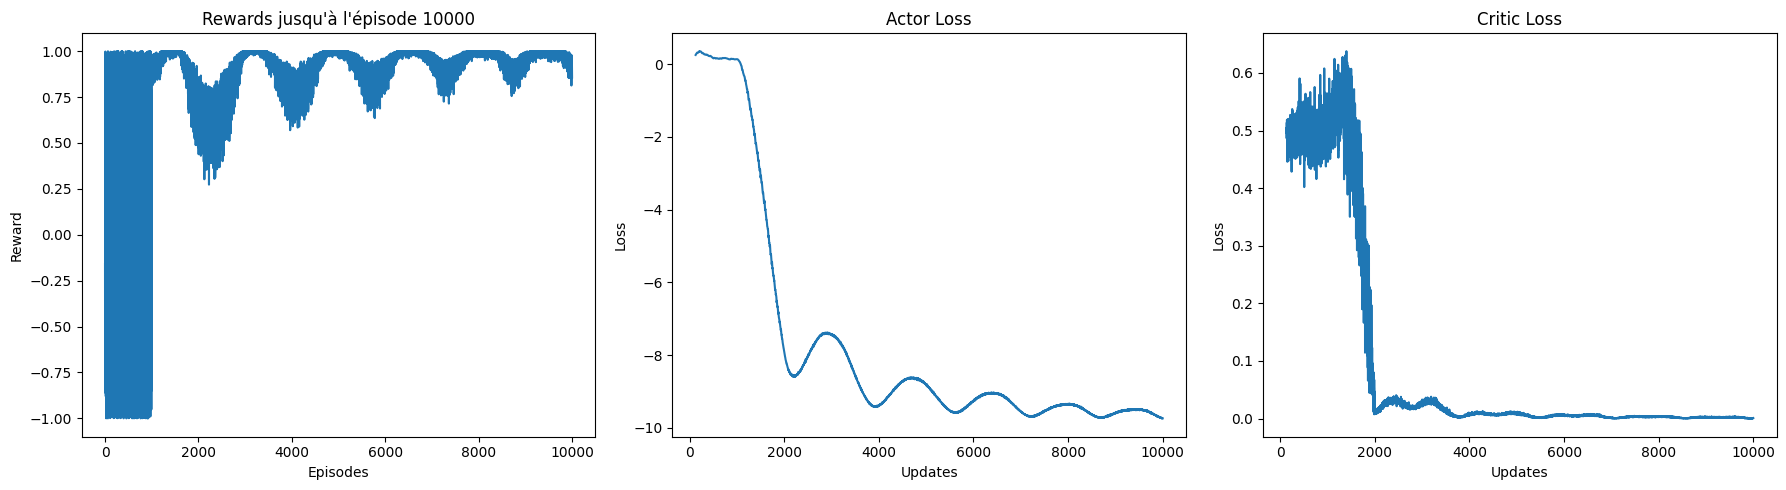

Episode 10000, Reward moyen: 0.8570042252540588
Prédictions test
etat [0.5288159]
Action prédite 0: tensor([[0.5563]], grad_fn=<MulBackward0>)
Valeur Q prédite 0: tensor([[9.7366]], grad_fn=<AddmmBackward0>)
recompense 0: 0.9844094844759067
etat [0.7864088]
Action prédite 1: tensor([[0.5563]], grad_fn=<MulBackward0>)
Valeur Q prédite 1: tensor([[9.7366]], grad_fn=<AddmmBackward0>)
recompense 1: 0.9844094844759067
etat [0.62599105]
Action prédite 2: tensor([[0.5563]], grad_fn=<MulBackward0>)
Valeur Q prédite 2: tensor([[9.7366]], grad_fn=<AddmmBackward0>)
recompense 2: 0.9844094844759067
etat [0.0124396]
Action prédite 3: tensor([[0.5563]], grad_fn=<MulBackward0>)
Valeur Q prédite 3: tensor([[9.7366]], grad_fn=<AddmmBackward0>)
recompense 3: 0.9844094844759067
etat [0.40876555]
Action prédite 4: tensor([[0.5563]], grad_fn=<MulBackward0>)
Valeur Q prédite 4: tensor([[9.7366]], grad_fn=<AddmmBackward0>)
recompense 4: 0.9844094844759067
etat [0.7239259]
Action prédite 5: tensor([[0.5563]],

In [ ]:
#================ Définir l'environnement ========================
env = SimpleEnv()
# Initialiser les réseaux avec les tailles d'état et d'action de l'environnement personnalisé

state_dim = 1  # Dimension de l'état pour l'environnement personnalisé
action_dim = 1  # Une seule action continue
max_action = 1.0  # La plage des actions est [-1, 1]

#=================================================================


#============ Initialiser l'acteur et le critique ================

actor = Actor(state_dim, action_dim, max_action)
critic = Critic(state_dim, action_dim)

# Initialiser les réseaux cibles
target_actor = Actor(state_dim, action_dim, max_action)
target_critic = Critic(state_dim, action_dim)

# Copier les poids des réseaux principaux vers les réseaux cibles
for target_param, param in zip(target_actor.parameters(), actor.parameters()):
    target_param.data.copy_(param.data)
for target_param, param in zip(target_critic.parameters(), critic.parameters()):
    target_param.data.copy_(param.data)

# Définir les optimiseurs
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

#===============================================================


# Initialiser la mémoire de replay
replay_buffer = ReplayBuffer(size=1000)

# Boucle d'entraînement
num_episodes = 10000
batch_size = 128
gamma = 0.9
tau = 0.05
initial_random_steps = 1000  # Nombre d'étapes aléatoires initiales
duree_episode = 1

#Bruit
mu = 0
theta = 0.15
sigma = 0.1

train(mu , theta , sigma , initial_random_steps, num_episodes, batch_size, gamma, tau, duree_episode)





#appel sur un exemple test
state, _ = env.reset(seed=42)
state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
# Prédiction de l'action
print("Prédictions test")
for i in range(10):
    action = actor(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    print(f"Action prédite {i}:", action)
    print(f"Valeur Q prédite {i}:", critic(state, action))
    print(f"recompense {i}:", reward)
plt.show()

### **Test sur pendulumV1**

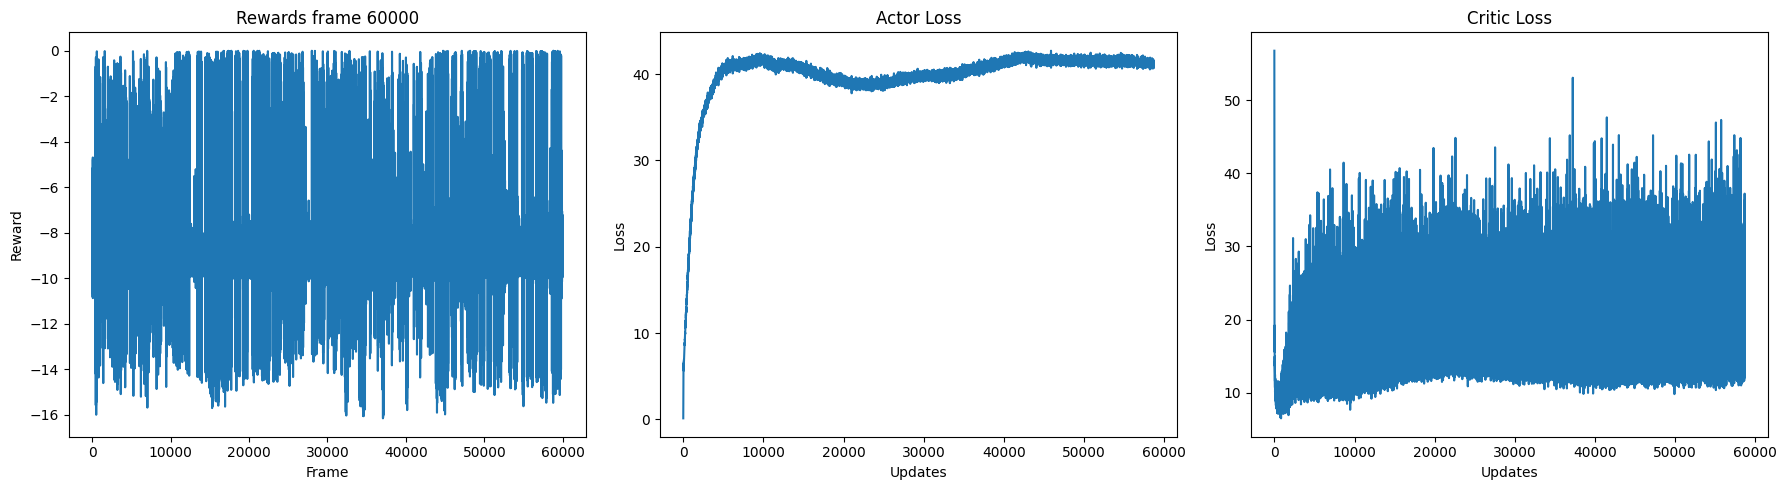

Episode 300, Reward moyen: 0


In [68]:


#================ Définir l'environnement ========================
env = gym.make("Pendulum-v1", render_mode="human") #"MountainCarContinuous-v0" #"LunarLanderContinuous-v3" #"Pendulum-v1"
#env = ActionNormalizer(env)
"""# Créer l'environnement avec enregistrement vidéo
env = gym.make("Pendulum-v1", render_mode="rgb_array")  # mode RGB pour enregistrer

# Envelopper avec RecordVideo pour capturer une vidéo
env = gym.wrappers.RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=lambda episode_id: True,  # enregistre chaque épisode
    name_prefix="pendulum-test
)"""



# Initialiser les réseaux avec les tailles d'état et d'action de l'environnement personnalisé

state_dim = 3  # Dimension de l'état pour l'environnement personnalisé
action_dim = 1  # Une seule action continue
max_action = 2.0  # La plage des actions est [-2, 2]

#=================================================================


#============ Initialiser l'acteur et le critique ================

actor = Actor(state_dim, action_dim, max_action)
critic = Critic(state_dim, action_dim)

# Initialiser les réseaux cibles
target_actor = Actor(state_dim, action_dim, max_action)
target_critic = Critic(state_dim, action_dim)

# Copier les poids des réseaux principaux vers les réseaux cibles
for target_param, param in zip(target_actor.parameters(), actor.parameters()):
    target_param.data.copy_(param.data)
for target_param, param in zip(target_critic.parameters(), critic.parameters()):
    target_param.data.copy_(param.data)

# Définir les optimiseurs
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

#===============================================================


# Initialiser la mémoire de replay
replay_buffer = ReplayBuffer(size=100000)

# Boucle d'entraînement
num_episodes = 300
batch_size = 256
gamma = 0.85
tau = 0.005
initial_random_steps = 1000  # Nombre d'étapes aléatoires initiales
duree_episode = 200

#Bruit
mu = 0
theta = 0.5
sigma = 0.05

train(mu , theta , sigma , initial_random_steps, num_episodes, batch_size, gamma, tau, duree_episode)





